# **Method**

1. Combined manta and environmental variables datasets into one data frame
2. Run linear regression between manta ray presence and all predictors (current, wind, salinity, temperature, chlorophyll)
3. Visualise these regressions
4. Use stepwise selection to choose best model based on cross-validation

Step 1: Combine datasets

In [132]:
# Load libraries
import pandas as pd
import numpy as np  
import xarray as xr
import os

In [133]:
# Define base directory
base_dir = "ModelSelection_Outputs"

In [134]:
# Import LEI variable data 
csv_path = os.path.join("VariableLooping_Outputs", "data", "full_LadyElliot_eReefs_timeseries.csv")

# Read the CSV file with whitespace separator adjusted
lei_df = pd.read_csv(csv_path)

In [135]:
# Load manta daily detections (for 2 residents)
csv_path = os.path.join("ModelSelection_Inputs", "manta_daily_summary (1).csv")

manta_df = pd.read_csv(csv_path)

In [136]:
# Load mean daily chlorophyll
csv_path = os.path.join("ModelSelection_Inputs", "mean_daily_chlorophyll (1).csv")

chla_df = pd.read_csv(csv_path)

In [137]:
# Check structure of all of these
lei_df.head()

,date,current,wind,salinity,temperature,u,v
0,2011-01-01,0.411769,8.225824,35.281070,26.402613,-0.254784,-0.021583
1,2011-01-02,0.423713,6.587533,35.289307,26.393246,-0.096774,-0.055034
2,2011-01-03,0.455849,3.598129,35.301105,26.457840,-0.011286,-0.002039
3,2011-01-04,0.500103,4.478415,35.305530,26.492310,-0.011998,-0.022685
4,2011-01-05,0.495757,4.246986,35.315357,26.430445,-0.026243,-0.060517


In [138]:
manta_df.head()

,transmitter_id,date,total_detections,valid_hours,avg_detections_per_hour,date_dt
0,A69-1601-32687,20/06/2011,55,5,11.000000,20/06/2011
1,A69-1601-32687,28/06/2011,22,2,11.000000,28/06/2011
2,A69-1601-32687,29/06/2011,139,12,11.583333,29/06/2011
3,A69-1601-32687,30/06/2011,42,7,6.000000,30/06/2011
4,A69-1601-32687,05/07/2011,95,9,10.555556,05/07/2011


In [140]:
chla_df.head()

,time,chlorophyll
0,2011-01-01,0.826464
1,2011-01-02,0.749699
2,2011-01-03,0.735544
3,2011-01-04,0.632903
4,2011-01-05,0.703904


We need to change the time column for chla_df, but we'll do that later. 

For now, lets merge Lei_df and manta_df

In [141]:
# Convert date columns to datetime
manta_df["date"] = pd.to_datetime(manta_df["date"], format="%d/%m/%Y")
lei_df["date"] = pd.to_datetime(lei_df["date"], format="%Y-%m-%d")

In [142]:
# Merge both datasets on 'date'
combined_df = pd.merge(manta_df, lei_df, on="date", how="inner")

In [143]:
# Lets check that
combined_df.head()

,transmitter_id,date,total_detections,valid_hours,avg_detections_per_hour,date_dt,current,wind,salinity,temperature,u,v
0,A69-1601-32687,2011-06-20,55,5,11.000000,20/06/2011,0.312271,2.397936,35.491646,22.037445,0.023685,-0.010339
1,A69-1601-32687,2011-06-28,22,2,11.000000,28/06/2011,0.390109,11.108160,35.533546,21.823017,-0.198755,0.056739
2,A69-1601-32687,2011-06-29,139,12,11.583333,29/06/2011,0.472053,12.440138,35.535660,21.859299,-0.299089,0.119322
3,A69-1601-32687,2011-06-30,42,7,6.000000,30/06/2011,0.585665,13.093818,35.540730,21.994509,-0.413656,0.169070
4,A69-1601-32687,2011-07-05,95,9,10.555556,05/07/2011,0.354659,4.290062,35.569530,22.093294,0.056264,-0.019609


In [144]:
# Lets get rid of the old date_dt
combined_df = combined_df.drop(columns=["date_dt"])

In [145]:
# Quick check
combined_df.head()

,transmitter_id,date,total_detections,valid_hours,avg_detections_per_hour,current,wind,salinity,temperature,u,v
0,A69-1601-32687,2011-06-20,55,5,11.000000,0.312271,2.397936,35.491646,22.037445,0.023685,-0.010339
1,A69-1601-32687,2011-06-28,22,2,11.000000,0.390109,11.108160,35.533546,21.823017,-0.198755,0.056739
2,A69-1601-32687,2011-06-29,139,12,11.583333,0.472053,12.440138,35.535660,21.859299,-0.299089,0.119322
3,A69-1601-32687,2011-06-30,42,7,6.000000,0.585665,13.093818,35.540730,21.994509,-0.413656,0.169070
4,A69-1601-32687,2011-07-05,95,9,10.555556,0.354659,4.290062,35.569530,22.093294,0.056264,-0.019609


Okay, now lets integrate chlorophyll data

In [153]:
# ensure both are datetime# Ensure both are datetime
combined_df["date"] = pd.to_datetime(combined_df["date"])
chla_df["time"] = pd.to_datetime(chla_df["time"])

In [154]:
# Merge the two datasets
combined_df = pd.merge(
    combined_df,
    chla_df.rename(columns={"time": "date"}),  # rename for consistency
    on="date",
    how="inner"
)

In [155]:
# Check all variables are accounted for
combined_df.head()

,transmitter_id,date,total_detections,valid_hours,avg_detections_per_hour,current,wind,salinity,temperature,u,v,chlorophyll
0,A69-1601-32687,2011-06-20,55,5,11.000000,0.312271,2.397936,35.491646,22.037445,0.023685,-0.010339,1.084986
1,A69-1601-32687,2011-06-28,22,2,11.000000,0.390109,11.108160,35.533546,21.823017,-0.198755,0.056739,1.494323
2,A69-1601-32687,2011-06-29,139,12,11.583333,0.472053,12.440138,35.535660,21.859299,-0.299089,0.119322,1.413709
3,A69-1601-32687,2011-06-30,42,7,6.000000,0.585665,13.093818,35.540730,21.994509,-0.413656,0.169070,1.215172
4,A69-1601-32687,2011-07-05,95,9,10.555556,0.354659,4.290062,35.569530,22.093294,0.056264,-0.019609,1.290393


Great, now we have a combined dataframe with all variables, called combined_df. Let's export this as a csv for selecting the best combination for a model.

In [156]:
# Store dataframe as a csv file so I don't need to rerun this cell
csv_path = os.path.join("ModelSelection_Outputs", "combined_data_output.csv")

combined_df.to_csv(csv_path, index=False)

Step 2: Linear Regression

In [157]:
# Load libraries
import itertools
import statsmodels.formula.api as smf

In [158]:
# Define predictors
predictors = ["current", "wind", "salinity", "temperature","chlorophyll", "u", "v"]

results = []

In [159]:
# Run linear regression
for manta_id, subdf in combined_df.groupby("transmitter_id"):
    # run all single-predictor regressions first
    for pred in predictors:
        formula = f"total_detections ~ {pred}"
        model = smf.ols(formula, data=subdf).fit()
        
        results.append({
            "manta_id": manta_id,
            "formula": formula,
            "AIC": model.aic,
            "BIC": model.bic,
            "R2": model.rsquared,
            "adjR2": model.rsquared_adj,
            "coeffs": model.params.to_dict(),
            "pvalues": model.pvalues.to_dict()
        })

In [160]:
# Put these results into a dataframe
results_df = pd.DataFrame(results)

In [161]:
# Lets have a look at these results
results_df

,manta_id,formula,AIC,BIC,R2,adjR2,coeffs,pvalues
0,A69-1601-32687,total_detections ~ current,3934.365795,3941.780016,0.012508,0.009205,"{'Intercept': 240.95365544525382, 'current': -...","{'Intercept': 1.5597718675588872e-07, 'current..."
1,A69-1601-32687,total_detections ~ wind,3924.251304,3931.665524,0.045139,0.041945,"{'Intercept': 251.18007956180907, 'wind': -14....","{'Intercept': 3.74491050015649e-18, 'wind': 0...."
2,A69-1601-32687,total_detections ~ salinity,3887.705923,3895.120143,0.154310,0.151482,"{'Intercept': 16132.600355686976, 'salinity': ...","{'Intercept': 9.568813429399588e-13, 'salinity..."
3,A69-1601-32687,total_detections ~ temperature,3896.265842,3903.680063,0.129915,0.127005,"{'Intercept': 1112.878441861083, 'temperature'...","{'Intercept': 1.4150215352490538e-13, 'tempera..."
4,A69-1601-32687,total_detections ~ chlorophyll,3937.994395,3945.408616,0.000531,-0.002812,"{'Intercept': 145.16908145283446, 'chlorophyll...","{'Intercept': 4.44093253917947e-07, 'chlorophy..."
5,A69-1601-32687,total_detections ~ u,3937.988117,3945.402337,0.000552,-0.002791,"{'Intercept': 156.35934764292884, 'u': 32.3698...","{'Intercept': 4.826134716634097e-42, 'u': 0.68..."
6,A69-1601-32687,total_detections ~ v,3938.073688,3945.487909,0.000268,-0.003076,"{'Intercept': 155.81206731335797, 'v': -34.784...","{'Intercept': 1.2790582225312473e-42, 'v': 0.7..."
7,A69-1601-32688,total_detections ~ current,9041.544274,9050.582568,0.007159,0.005690,"{'Intercept': 667.9923157884934, 'current': -1...","{'Intercept': 1.0842124962079454e-67, 'current..."
8,A69-1601-32688,total_detections ~ wind,9045.635778,9054.674072,0.001149,-0.000328,"{'Intercept': 577.2281948173467, 'wind': 2.418...","{'Intercept': 3.3646893948232247e-115, 'wind':..."
9,A69-1601-32688,total_detections ~ salinity,9016.806098,9025.844392,0.042732,0.041316,"{'Intercept': -6069.04113068792, 'salinity': 1...","{'Intercept': 7.193117893226791e-07, 'salinity..."


Step 3: Visualise this regression

In [162]:
# Load necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

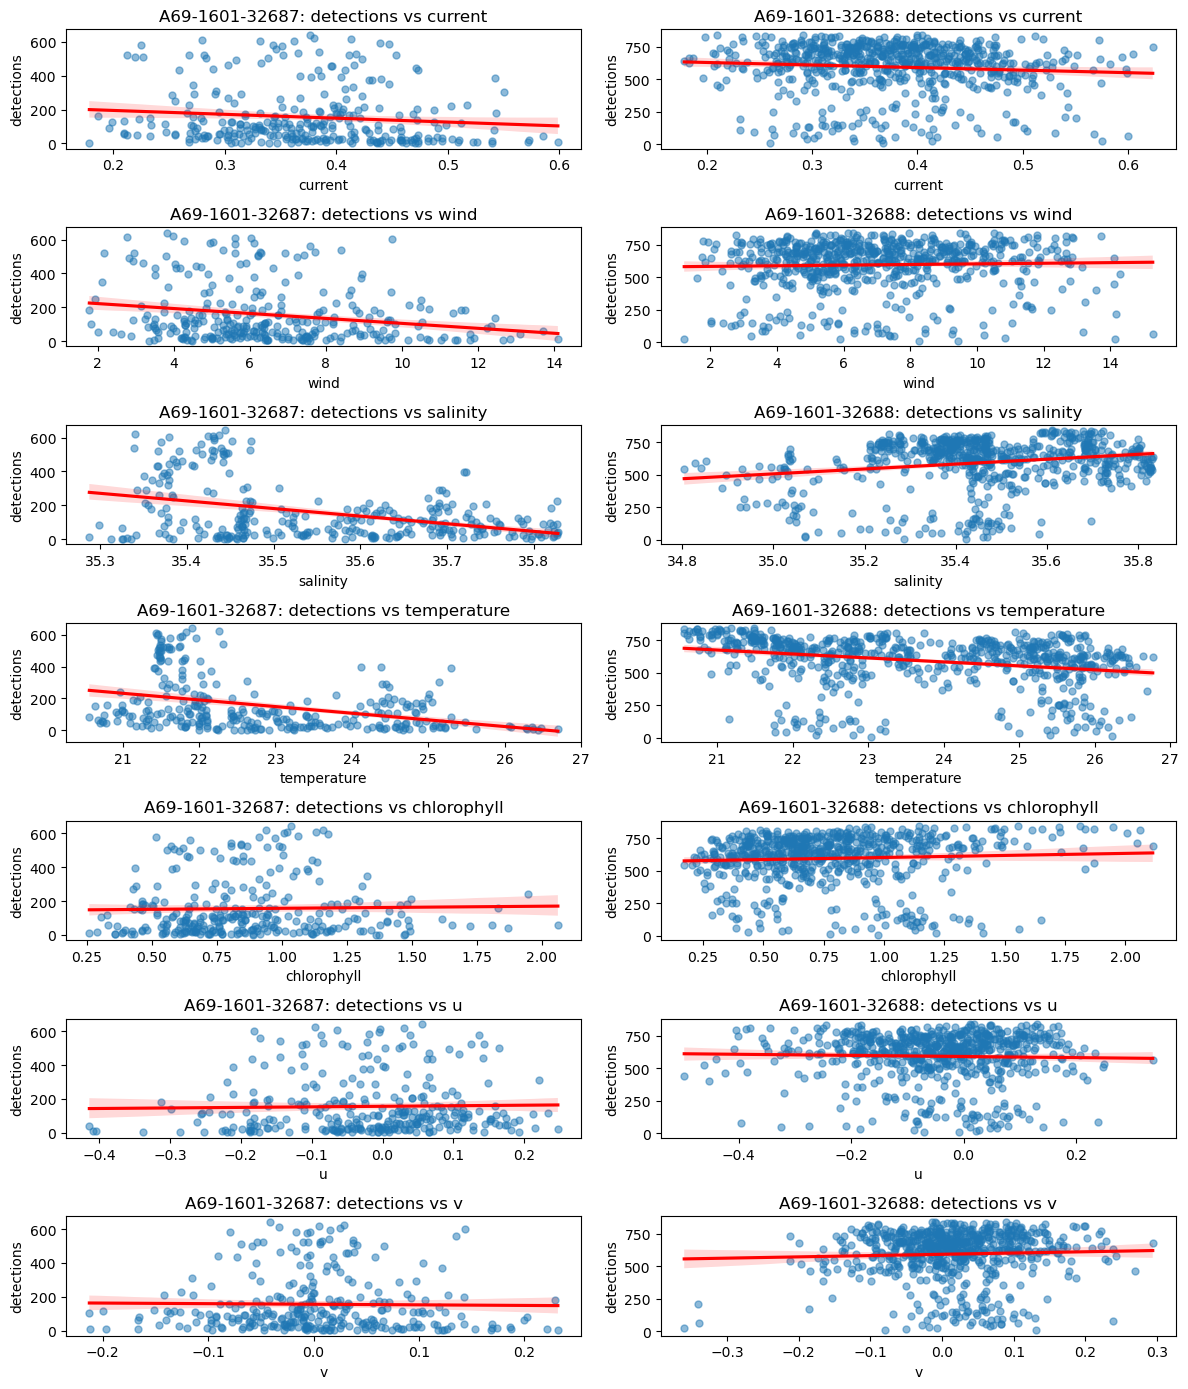

In [163]:
# Plotting this regression
predictors = ["current", "wind", "salinity", "temperature","chlorophyll", "u", "v"]
manta_ids = combined_df["transmitter_id"].unique()

# Create figure with 4 rows (predictors) x 2 columns (mantas)
fig, axes = plt.subplots(len(predictors), len(manta_ids), figsize=(12, 14))

for row, pred in enumerate(predictors):
    for col, manta_id in enumerate(manta_ids):
        ax = axes[row, col]
        
        # subset data for this manta
        subdf = combined_df[combined_df["transmitter_id"] == manta_id]
        
        # regression plot
        sns.regplot(
            data=subdf,
            x=pred,
            y="total_detections",
            scatter_kws={"alpha":0.5, "s":25},
            line_kws={"color":"red"},
            ax=ax
        )
        
        ax.set_title(f"{manta_id}: detections vs {pred}")
        ax.set_xlabel(pred)
        ax.set_ylabel("detections")

plt.tight_layout()
plt.show()

Okay so the regression is not very strong. It is likely that a mixed model will not find anything, but let's give it a try!

Step 4: Find the model of best fit

In [164]:
# Import libraries
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

In [165]:
# Run a stepwise model comparison using the Sequential Feature Selector
predictors = ["current", "wind", "salinity", "temperature", "chlorophyll", "u", "v"]

results = {}

for manta_id, subdf in combined_df.groupby("transmitter_id"):
    X = subdf[predictors]
    y = subdf["total_detections"]

    # stepwise feature selection
    sfs = SequentialFeatureSelector(
        LinearRegression(),
        k_features="best",
        forward=True,
        scoring="r2",
        cv=5
    ).fit(X, y)

    best_feats = list(sfs.k_feature_names_)
    best_score = sfs.k_score_

    results[manta_id] = {
        "selected_predictors": best_feats,
        "CV_R2": best_score
    }

In [166]:
# Put the results of these into a results table
mm_results_df = pd.DataFrame([
    {"manta_id": m, "selected_predictors": ", ".join(res["selected_predictors"]), "CV_R2": res["CV_R2"]}
    for m, res in results.items()
])

In [167]:
# Lets have a look at this data
mm_results_df

,manta_id,selected_predictors,CV_R2
0,A69-1601-32687,v,-1.677161
1,A69-1601-32688,current,-0.545985


Uh oh! A negative cross-validated R2 score is really bad. We were right, this wasn't a good choice!